## Bài toán (Bỏ KNN - Chỉ sử dụng TF)
Dữ liệu gồm 1135 văn bản phân vào 10 chủ đề khác nhau. Cần xây dựng và đánh giá các mô hình dự đoán nhãn của các văn bản trên.

## Đánh giá và tối ưu hoá mô hình 

- Lựa chọn các giá trị của các tham số bằng các thử nghiệm. 
- Với mỗi bộ tham số: 
    - Sử dụng phương pháp cross-validate chia dữ liệu và training, để đánh giá mô hình một cách tổng quát. 
- Sử dụng độ đo Accuracy để làm độ đo đánh giá chất lượng mô hình. 
- Với mỗi mô hình, tìm ra bộ tham số tốt nhất, và tiếp tục thử các mô hình khác. 
- So sánh các mô hình

## Mục lục
- Load dữ liệu từ thư mục
- Chuyển dữ liệu dạng text về ma trận (n x m) bằng tfidf. Chuyển nhãn các văn bản về dạng số.
- Lựa chọn tham số các mô hình KNN (K), SVM (kernel, C), Random Forest (criteria, N)
- So sánh 3 mô hình tốt nhất
- Đánh giá sự ảnh hưởng của việc sử dụng stopwords

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

from sklearn.datasets.base import load_files
from pyvi import ViTokenizer


from sklearn import svm
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.datasets.base import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

/home/vutrungnghia/miniconda3/envs/env_38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/vutrungnghia/miniconda3/envs/env_38/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load dữ liệu từ thư mục

Cấu trúc thư mục như sau 

- data_sample/news_1135/

    - Kinh tế: 
        - bài báo 1.txt 
        - bài báo 2.txt 
    - Pháp luật
        - bài báo 3.txt 
        - bài báo 4.txt 

In [2]:
INPUT = 'data_sample/news_1135'
os.makedirs("images",exist_ok=True)  # thư mục lưu các các hình ảnh trong quá trình huấn luyện và đánh gía

In [3]:
# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))

print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
Giải trí: 107
Khoa học - Công nghệ: 196
Kinh tế: 186
Pháp luật: 50
Sức khỏe: 75
Thể thao: 140
Thời sự: 138
Tin khác: 100
Đời sống - Xã hội: 91
Độc giả: 52
-------------------------
Tổng số văn bản: 1135


In [17]:
# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")

print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])

print("\nTổng số  file: {}" .format( len(data_train.filenames)))

mapping:
Giải trí - 0
Khoa học - Công nghệ - 1
Kinh tế - 2
Pháp luật - 3
Sức khỏe - 4
Thể thao - 5
Thời sự - 6
Tin khác - 7
Đời sống - Xã hội - 8
Độc giả - 9
--------------------------
['data_sample/news_1135/Tin khác/0218e1df21ce358b9c6485176a48f1fcaeedef67.txt']
[7]
['Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách c

## Chuyển dữ liệu dạng text về ma trận (n x m) bằng tfidf. Chuyển nhãn các văn bản về dạng số

In [5]:
# load dữ liệu các stopwords 
with open("vietnamese-stopwords.txt") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# 
# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 24389
Kích thước dữ liệu sau khi xử lý: (1135, 24389)
Kích thước nhãn tương ứng: (1135,)


## Lựa chọn tham số các mô hình KNN (K), SVM (kernel, C), Random Forest (criteria, N)

- Viết hàm thực hiện huấn luyện mô hình và đánh giá theo cross-validation,
- Sử dụng các thư viện hỗ trợ để vẽ đồ thị toàn bộ quá trình huấn luyện

In [6]:
# # hàm sinh id màu  
# def get_cmap(n):
#     return 'C' + str(n)

# # Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng mat libplot 
# def plot_learning_curve(estimator, title, label_curve, X, y, ylim=None, cv=None,
#                         n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), new_plot=False,
#                         idx_color=0):
    
#     # Khởi tạo bức ảnh mới với thư viện plot lib
#     if new_plot:
#         # plt.figure()
#         plt.title(title)
#         plt.xlabel("Training examples")
#         plt.ylabel("Accuracy")
#         plt.grid()
    
#     # chú thích nếu có 
#     if ylim is not None:
#         plt.ylim(*ylim)
        
#     #
#     # thực hiện training model, ghi nhận các giá trị trong quá trình training 
#     # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
#     # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
#     #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
#     # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
#     # Lấy trung bình cộng các giá trị output của các fold
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
    
#     # random 1 màu để vẽ 
#     color = get_cmap(idx_color)
    
#     # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color=color)
#     plt.plot(train_sizes, test_scores_mean, 'o-', color=color,
#              label=label_curve)

#     plt.legend(loc="best")
#     return plt

### Thay đổi tham số kernel của mô hình SVM 

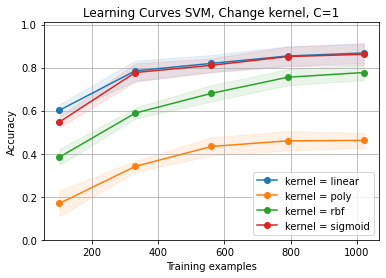

In [8]:
title = "Learning Curves SVM, Change kernel, C=1"

for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với từng giá trị C nhận được, 
    # thực hiện build model và training cross-validate
    # vẽ kết quả tìm được lên đồ thị đường.
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    
    plt = plot_learning_curve(text_clf, title, f"kernel = {kernel}",
                              data_preprocessed, data_train.target,
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

# lưu hình ảnh ra file 
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()


### Thay đổi tham số C của mô hình SVM

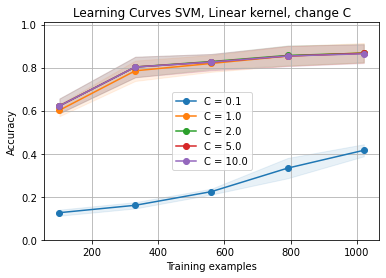

In [9]:
title = "Learning Curves SVM, Linear kernel, change C"

for i, C in enumerate([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được,
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = svm.SVC(kernel='linear', C=C)
    
    plt = plot_learning_curve(text_clf, title, "C = %0.1f" % (C),
                              data_preprocessed, data_train.target,
                              (0.0, 1.01), cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)

# lưu hình ảnh ra file 
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()


### Thay đổi tham số criterion của mô hình Random Forest

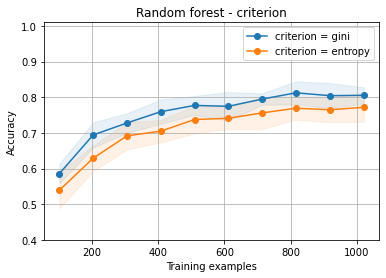

In [10]:
title = "Random forest - criterion"

# duyệt qua mảng các giá trị của tham số criterion 
for i, criterion in enumerate(["gini", "entropy"]):
    # Với từng giá trị criterion nhận được, 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    plt = plot_learning_curve(text_clf, title, "criterion = {}".format(criterion),
                              data_preprocessed, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()


### Thay đổi số cây quyết định trong mô hình Random Forest 

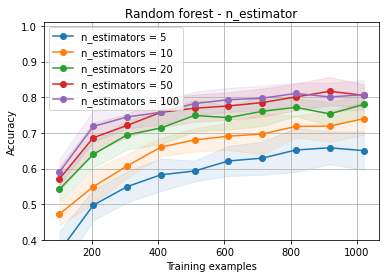

In [11]:
title = "Random forest - n_estimator"

# duyệt qua mảng các giá trị của tham số n_estimators 
for i, n_estimators in enumerate([5, 10, 20, 50, 100]):
    
    # Với từng giá trị n_estimators nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    plt = plot_learning_curve(text_clf, title, "n_estimators = {}".format(n_estimators),
                              data_preprocessed, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
# lưu hình ảnh ra file 
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()

## So sánh các mô hình với các bộ tham số tốt nhất  

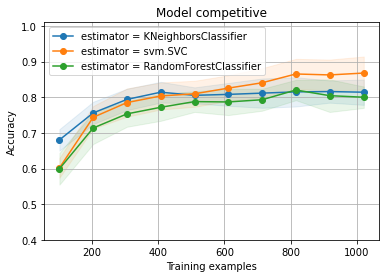

In [12]:
title = "So sánh các mô hình"

best_models = [
    KNeighborsClassifier(n_neighbors=10),
    svm.SVC(kernel='linear', C=1.0),
    RandomForestClassifier(criterion='gini', n_estimators=100)
]
best_models_name = [
    'KNeighborsClassifier',
    'svm.SVC',
    'RandomForestClassifier'
]

for i, estimator in enumerate(best_models):
    
    # Với từng giá trị model, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = estimator
    plt = plot_learning_curve(text_clf, title, "estimator = {}".format(best_models_name[i]),
                              data_preprocessed, data_train.target,
                              (0.4, 1.01),
                              train_sizes=np.linspace(.1, 1.0, 10),
                              cv=10, n_jobs=-1, idx_color=i, new_plot=i == 0)
plt.savefig('images/model_comparison.png', bbox_inches='tight')
plt.show()